# Basic Generative Adversarial Network to generate MNIST images

This code creates two networks: a generator and a discriminator. The discriminator tries to determine if it's input is coming from real MNIST data or not and the generator tries to fool the discriminator. The generator (which is the network that is making the images seen below) never actually sees data from the training set, it just connects to the discriminator and has a loss function based on the discriminator's output.


In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import range
import pylab as pl
import time
from IPython import display

%matplotlib inline

In [65]:
pl.rcParams["figure.figsize"] = 15,15

def plot_images(session,image_graph):
    #images = session.run([image_graph], feed_dict={tf_test_numerals : np.identity(64)})
    images = session.run([image_graph])
    images = np.squeeze(images)
    edge_size = np.sqrt(images.shape[0])
    new_row = []
    for i in xrange(images.shape[0]):
        new_row.append(images[i])
        if (i + 1) % edge_size == 0:
            if i < edge_size: #full_image doesn't exist yet
                full_image = np.hstack(new_row)
            else:
                full_image = np.vstack([full_image,np.hstack(new_row)])
            new_row = []
    pl.imshow(full_image,cmap="gray")
    display.display(pl.gcf())
    time.sleep(1.0)

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [78]:
batch_size = 64
patch_size = 5
depth = 16
num_hidden = 64

image_size = 28
num_labels = 10
num_channels = 1 # grayscale

random_vector_size = 64

graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels)) #images
    tf_train_numerals = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) #numerals
    tf_train_random = tf.placeholder(tf.float32, shape=(batch_size, random_vector_size)) #numerals
    tf_test_numerals = tf.placeholder(tf.float32, shape=(random_vector_size, random_vector_size)) #numerals

    # Variables for generator
    hidden_layer1_size = 50
    glayer1_weights = tf.Variable(tf.truncated_normal([random_vector_size,hidden_layer1_size], stddev=0.1), name="generator/w1")
    glayer1_biases = tf.Variable(tf.zeros([hidden_layer1_size]), name="generator/b1")
    glayer2_weights = tf.Variable(tf.truncated_normal([hidden_layer1_size,image_size * image_size], stddev=0.1), name="generator/w2")
    glayer2_biases = tf.Variable(tf.zeros([image_size * image_size]), name="generator/b2")
    
    # Variables for deconv generator
    deconv_filter_1 = tf.Variable(tf.truncated_normal([5,5,256,1], stddev=0.1), name="generator/deconv/filter1")
    deconv_filter_2 = tf.Variable(tf.truncated_normal([8,8,64,256], stddev=0.1), name="generator/deconv/filter2")
    deconv_filter_3 = tf.Variable(tf.truncated_normal([10,10,1,64], stddev=0.1), name="generator/deconv/filter3")
    deconv_bias_1 = tf.Variable(tf.zeros([256]), name="generator/deconv/biases1")
    deconv_bias_2 = tf.Variable(tf.zeros([64]), name="generator/deconv/biases2")
    deconv_bias_3 = tf.Variable(tf.zeros([1]), name="generator/deconv/biases3")

    # Variables for classifier
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1), name="classifier/w1")
    layer1_biases = tf.Variable(tf.zeros([depth]), name="classifier/b1")
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1), name="classifier/w2")
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]), name="classifier/b2")
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1), name="classifier/w3")
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name="classifier/b3")
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, 1], stddev=0.1), name="classifier/w4")
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[1]), name="classifier/b4")

    # Model.
    def classifier_model(data):
        with graph.as_default():
            conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME', name="classifier/c1")
            hidden = tf.nn.relu(conv + layer1_biases)
            conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
            hidden = tf.nn.relu(conv + layer2_biases)
            shape = hidden.get_shape().as_list()
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
            return (tf.matmul(hidden, layer4_weights) + layer4_biases)

    def generator_model(labels):
        hidden1 = tf.nn.relu(tf.matmul(labels, glayer1_weights) + glayer1_biases)
        hidden2 = tf.sigmoid(tf.matmul(hidden1, glayer2_weights) + glayer2_biases)
        return tf.reshape(hidden2,[-1,image_size, image_size,1])
    
    def deconv_generator_model(noise):
        square_noise = tf.reshape(noise, [-1,8,8,1])
        print("sq noise shape= {0}".format(square_noise.get_shape()))
        num_examples = batch_size
        fm1 = tf.nn.conv2d_transpose(value=square_noise, #[10,8,8,1]
                                     filter=deconv_filter_1, #[5,5,64,1]
                                     output_shape=[num_examples,12,12,256],
                                     strides=[1,1,1,1],
                                     padding='VALID', name=None)
        layer1 = tf.nn.bias_add(fm1,deconv_bias_1)
        print("layer1 shape= {0}".format(layer1.get_shape()))
        fm2 = tf.nn.conv2d_transpose(value=layer1,
                                     filter=deconv_filter_2,
                                     output_shape=[num_examples,19,19,64],
                                     strides=[1,1,1,1],
                                     padding='VALID', name=None)
        print("deconv bias2 shape= {0}".format(deconv_bias_2.get_shape()))
        layer2 = tf.nn.bias_add(fm2,deconv_bias_2)
        print("layer2 shape= {0}".format(layer2.get_shape()))
        fm3 = tf.nn.conv2d_transpose(value=layer2,
                                     filter=deconv_filter_3,
                                     output_shape=[num_examples,28,28,1],
                                     strides=[1,1,1,1],
                                     padding='VALID', name=None)
        layer3 = tf.nn.bias_add(fm3,deconv_bias_3)
        print("layer3 shape= {0}".format(layer3.get_shape()))
        output = tf.reshape(layer3,[-1,image_size, image_size,1])
        print("output shape= {0}".format(output.get_shape()))
        return output

    #Generator Loss
    sample_points = tf.constant(np.random.uniform(0,1,(batch_size,random_vector_size)).astype(np.float32))
    test_image = generator_model(sample_points)
    test_image = deconv_generator_model(sample_points)
    generated_image = deconv_generator_model(tf_train_random)
    
    generator_logits = classifier_model(generated_image)
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(generator_logits, tf.ones([batch_size,1])))

    # Generator Optimizer
    generator_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator/deconv")
    generator_optimizer = tf.train.AdagradOptimizer(0.05).minimize(generator_loss, var_list=generator_variables)  

    # Discriminator Loss
    classifier_real_logits = classifier_model(tf_train_dataset)
    classifier_real_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(classifier_real_logits, tf.ones([batch_size,1])))

    classifier_fake_logits = classifier_model(generated_image)
    classifier_fake_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(classifier_fake_logits, tf.zeros([batch_size,1])))

    classifier_loss = classifier_real_loss + classifier_fake_loss

    # Discriminator Optimizer.
    classifier_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "classifier")
    classifier_optimizer = tf.train.AdagradOptimizer(0.05).minimize(classifier_loss, var_list=classifier_variables)

sq noise shape= (64, 8, 8, 1)
layer1 shape= (64, 12, 12, 256)
deconv bias2 shape= (64,)
layer2 shape= (64, 19, 19, 64)
layer3 shape= (64, 28, 28, 1)
output shape= (64, 28, 28, 1)
sq noise shape= (64, 8, 8, 1)
layer1 shape= (64, 12, 12, 256)
deconv bias2 shape= (64,)
layer2 shape= (64, 19, 19, 64)
layer3 shape= (64, 28, 28, 1)
output shape= (64, 28, 28, 1)


Initialized
Step 0
Real and Fake loss: [22.699085, 0.0]
Generator Loss 26.9878101349


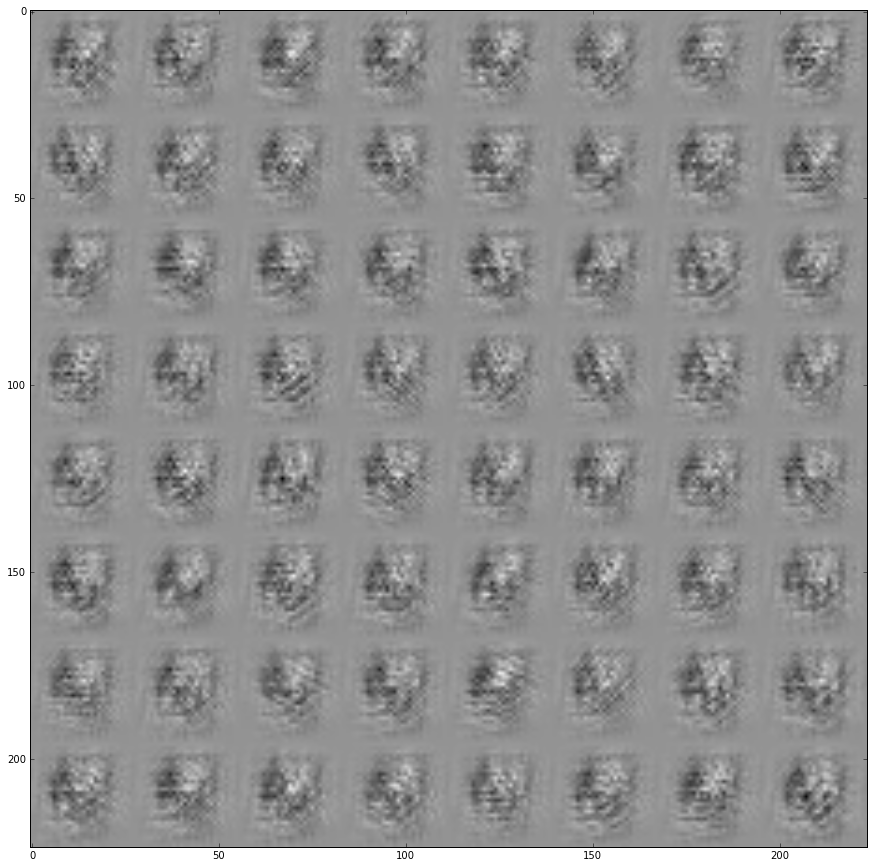

Step 100
Real and Fake loss: [1.9978637, 0.015364648]
Generator Loss 4.25361347198


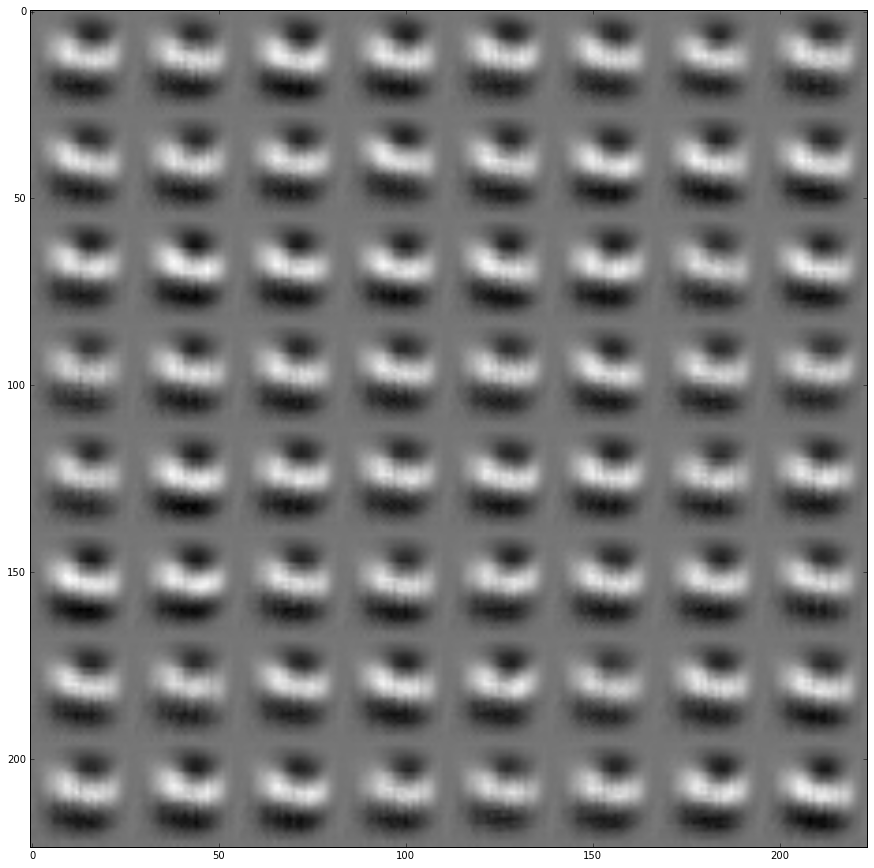

Step 200
Real and Fake loss: [0.56876206, 0.52147597]
Generator Loss 0.906630694866


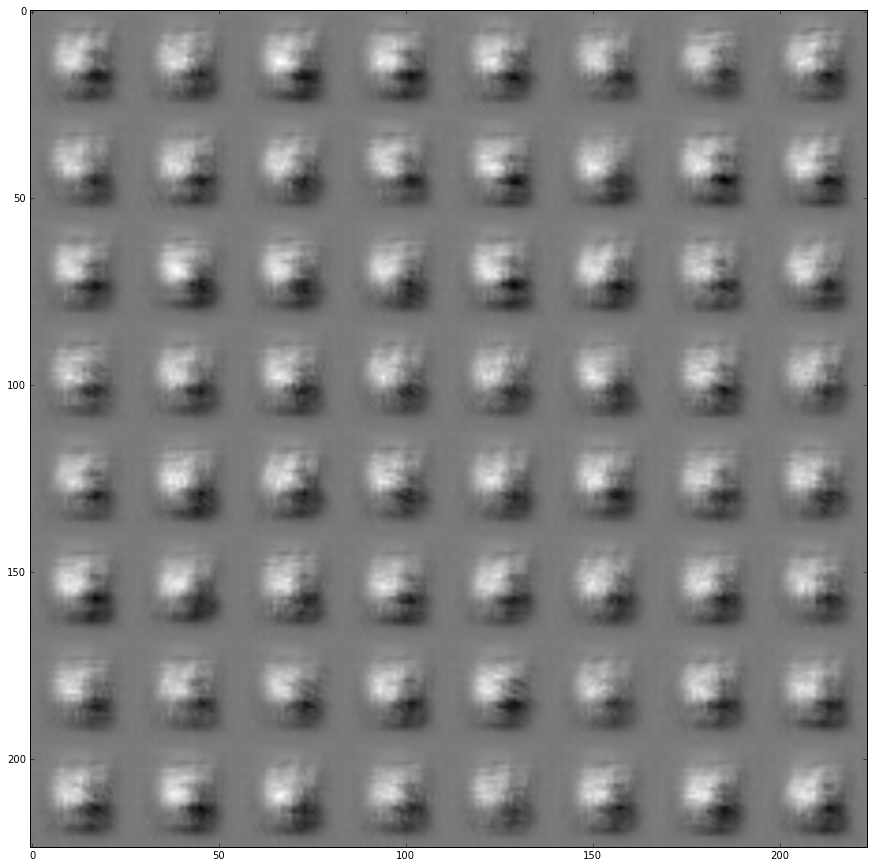

Step 300
Real and Fake loss: [0.87510991, 0.24410732]
Generator Loss 1.54341721535


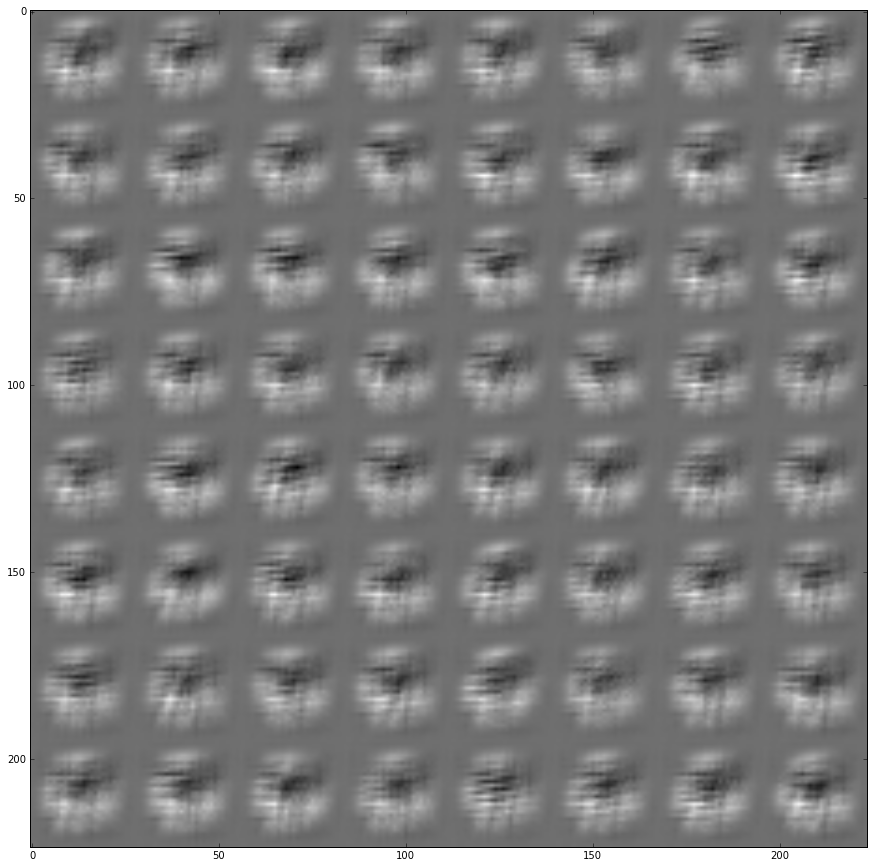

Step 400
Real and Fake loss: [1.2930609, 0.20793958]
Generator Loss 1.68610024452


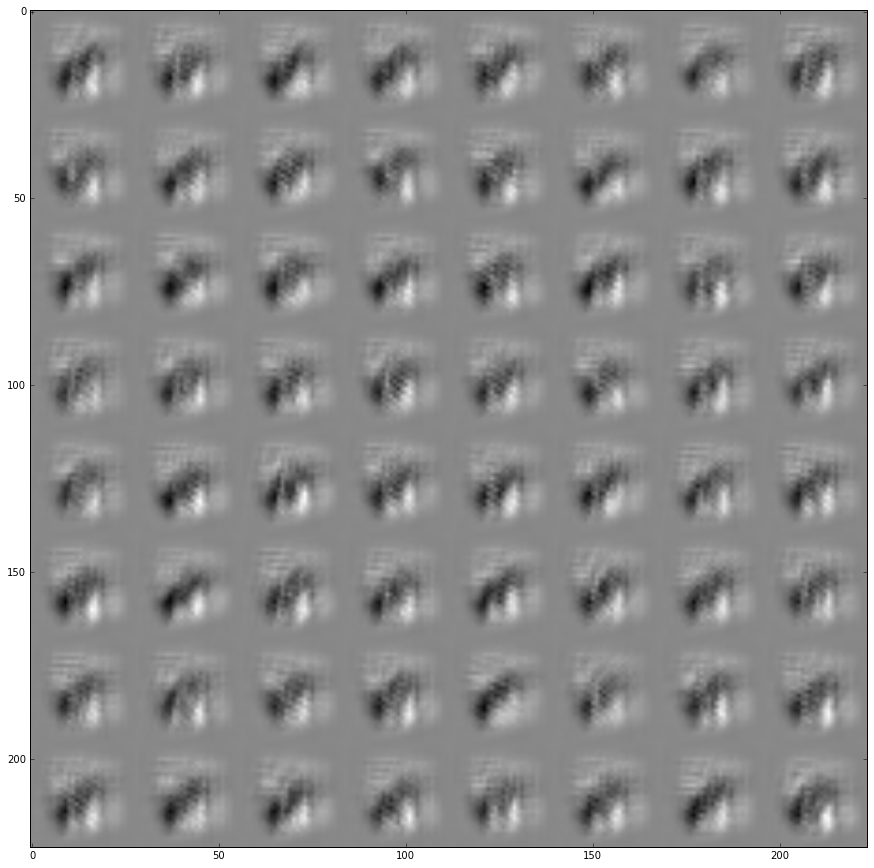

Step 500
Real and Fake loss: [0.74603599, 0.26769817]
Generator Loss 1.47784388065


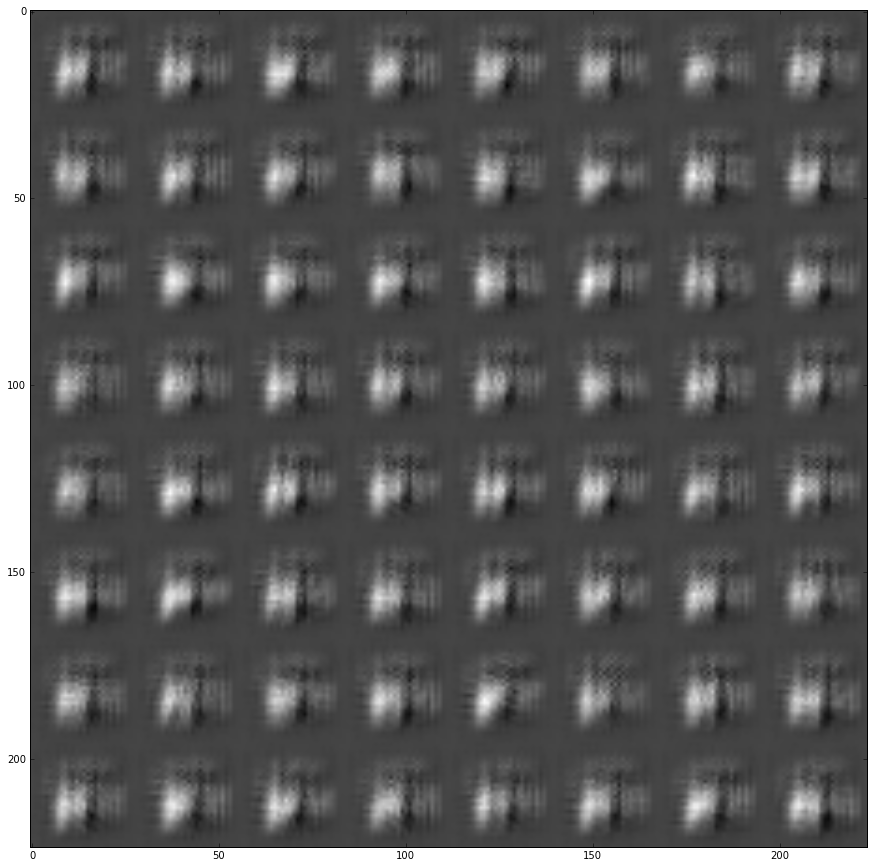

In [ ]:
num_steps = 70000
training_thresh = 0.1
updating = 'discriminator'
step = 0
updated_generator=True
l1,l2,l3 = .5, .5, .5

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')

    for step in range(num_steps):
        # prepare batch of training data
        batch_data, batch_labels = mnist.train.next_batch(batch_size)
        batch_data = batch_data.reshape([-1,28,28,1])
        feed_dict = {tf_train_dataset : batch_data, tf_train_numerals : batch_labels, tf_train_random: np.random.normal(0,1.0/np.sqrt(64),(batch_size,random_vector_size)).astype(np.float32)}

        # decide if we should change which model to update
        if float(l3)<training_thresh and updating=='generator':
            print("Updating discriminator...")
            updating='discriminator'
        elif float(l2+l1)<training_thresh and updating=='discriminator':
            print("Updating generator...")
            updating='generator'
        
        if updating == 'generator':
            updated_generator=True

        # update model
        #if updating=='discriminator':
        #    _ = session.run([classifier_optimizer], feed_dict=feed_dict)
        #elif(updating=='generator'):
        #    _ = session.run([generator_optimizer], feed_dict=feed_dict)
        if l3<l1+l2:
            _ = session.run([classifier_optimizer], feed_dict=feed_dict)
        else:
            _ = session.run([generator_optimizer], feed_dict=feed_dict)
            _ = session.run([generator_optimizer], feed_dict=feed_dict)
            updated_generator=True

        # log/debug    
        images, l3,l1, l2 = session.run([generated_image, generator_loss, classifier_real_loss, classifier_fake_loss], feed_dict=feed_dict)
        if (step % 100 == 0):
            print("Step {0}".format(step))
            print("Real and Fake loss: {0}".format([l1,l2]))
            print("Generator Loss {0}".format(l3))
            if updated_generator:
                plot_images(session,test_image)
                updated_generator=False